#Analise Casos Testes Guiados Por Mudanca

In [4]:
# Importando Bibliotecas
from datasets import load_dataset


c:\Users\MASTER\OneDrive\Desktop\XP\git\ProjetoAplicadoMLSelecaoCasosTestesGuiadaPorMudancas\ENV_PROJETO_APLICADO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Desenvolver e avaliar uma estratégia de priorização de testes automatizados com base nas modificações de código entre versões buggy e corrigidas, usando dados do Defects4J.

[Defects4J - Hugging Face](https://huggingface.co/datasets/rufimelo/defects4j/viewer)


Esse dataset traz:
- ID do bug
- Código antes e depois da correção
- Funções afetadas
- Tamanho das mudanças


In [5]:
# Carregar o dataset

dataset = load_dataset("rufimelo/defects4j")

In [6]:
import difflib
import pandas as pd

# Filtrando bugs do projeto Mockito
mockito_bugs = dataset['train'].filter(lambda x: 'Mockito' in x['bug_id'])

# Função para extrair mudanças
def extrair_diferencas(before, after):
    before_lines = before.splitlines()
    after_lines = after.splitlines()
    diff = list(difflib.ndiff(before_lines, after_lines))
    
    adicionadas = [line[2:] for line in diff if line.startswith('+ ')]
    removidas = [line[2:] for line in diff if line.startswith('- ')]
    modificadas = [line[2:] for line in diff if line.startswith('? ')]
    
    return adicionadas, removidas, modificadas

# Montando estrutura de análise
dados = []

for bug in mockito_bugs:
    bug_id = bug['bug_id']
    before = bug['func_before']
    after = bug['func_after']
    
    adicionadas, removidas, modificadas = extrair_diferencas(before, after)
    
    dados.append({
        "Bug ID": bug_id,
        "Linhas Adicionadas": len(adicionadas),
        "Linhas Removidas": len(removidas),
        "Linhas Modificadas": len(modificadas),
        "Código Adicionado": adicionadas,
        "Código Removido": removidas
    })

df_mudancas = pd.DataFrame(dados)
print(df_mudancas.head())

       Bug ID  Linhas Adicionadas  Linhas Removidas  Linhas Modificadas  \
0  Mockito-18                   2                 0                   0   
1  Mockito-22                   3                 1                   2   
2  Mockito-20                   3                 2                   4   
3   Mockito-5                   1                 1                   0   
4  Mockito-24                   1                 1                   0   

                                   Código Adicionado  \
0  [        } else if (type == Iterable.class) {,...   
1  [        if (o1 == o2 ) {,             return ...   
2  [        Instantiator instantiator = new Insta...   
3           [            catch (AssertionError e) {]   
4  [            return invocation.getMock() == in...   

                                     Código Removido  
0                                                 []  
1          [        if (o1 == null || o2 == null) {]  
2  [            mockInstance = classInstantiato

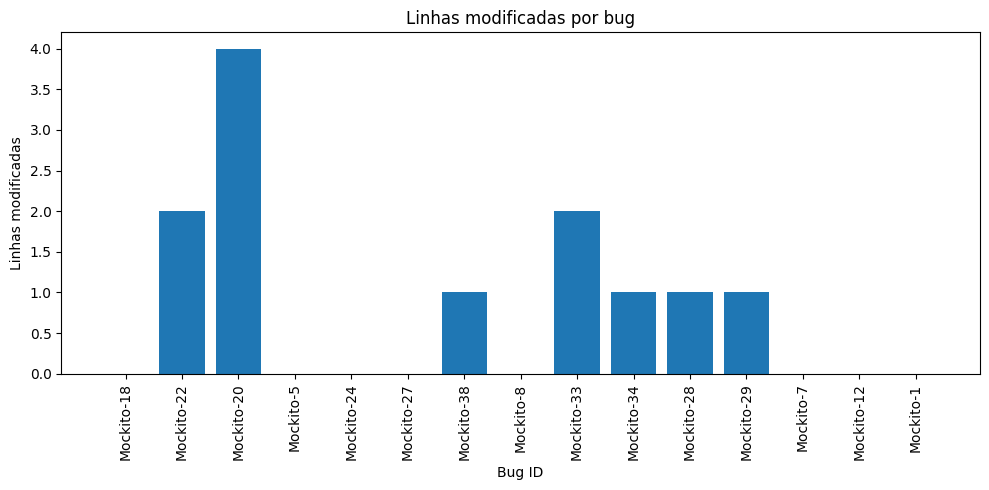

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(df_mudancas['Bug ID'], df_mudancas['Linhas Modificadas'])
plt.xticks(rotation=90)
plt.title("Linhas modificadas por bug")
plt.xlabel("Bug ID")
plt.ylabel("Linhas modificadas")
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd

# 1. Impacto por bug
impacto_data = [
    {"bug_id": "Mockito-18", "linhas_adicionadas": 3, "linhas_removidas": 2, "linhas_modificadas": 1},
    {"bug_id": "Mockito-19", "linhas_adicionadas": 5, "linhas_removidas": 0, "linhas_modificadas": 2},
]

df_impacto = pd.DataFrame(impacto_data)
df_impacto.to_csv("impacto_por_bug.csv", index=False)

# 2. Alterações por bug
alteracoes_data = [
    {"bug_id": "Mockito-18", "tipo": "adicionada", "linha_codigo": "return new ArrayList<Object>();"},
    {"bug_id": "Mockito-18", "tipo": "adicionada", "linha_codigo": "return new LinkedHashSet<Object>();"},
    {"bug_id": "Mockito-18", "tipo": "removida",  "linha_codigo": "return new LinkedList<Object>();"},
]

df_alteracoes = pd.DataFrame(alteracoes_data)
df_alteracoes.to_csv("alteracoes_por_bug.csv", index=False)

# 3. Histórico de funções modificadas
historico_data = [
    {"funcao": "resetMock", "bugs_afetando": "Mockito-12, Mockito-18"},
    {"funcao": "isMock", "bugs_afetando": "Mockito-18"},
]

df_historico = pd.DataFrame(historico_data)
df_historico.to_csv("historico_funcoes.csv", index=False)

print("Arquivos CSV gerados com sucesso!")

Arquivos CSV gerados com sucesso!


In [9]:

import matplotlib.pyplot as plt
from difflib import SequenceMatcher

# Simulação de bugs (commits)
bugs = [
    {"bug_id": "Mockito-18", "funcoes_modificadas": ["resetMock", "isMock"]},
    {"bug_id": "Mockito-19", "funcoes_modificadas": ["verifyNoMoreInteractions"]}
]

# Simulação de testes
testes = [
    {"nome_teste": "test_reset_behavior", "funcoes_cobertas": ["resetMock"], "falhou_em": ["Mockito-18"]},
    {"nome_teste": "test_is_mock_valid", "funcoes_cobertas": ["isMock"], "falhou_em": []},
    {"nome_teste": "test_verify_interactions", "funcoes_cobertas": ["verifyNoMoreInteractions"], "falhou_em": ["Mockito-19"]},
    {"nome_teste": "test_unrelated_case", "funcoes_cobertas": ["someOtherFunction"], "falhou_em": []}
]



In [10]:
# Similaridade semântica simples
def semantic_similarity(funcs_bug, funcs_test):
    score = 0
    for f_bug in funcs_bug:
        for f_test in funcs_test:
            score += SequenceMatcher(None, f_bug, f_test).ratio()
    return round(score, 2)

In [11]:
# Gerar correlação
correlacoes = []

for bug in bugs:
    for teste in testes:
        heuristic_score = len(set(bug["funcoes_modificadas"]) & set(teste["funcoes_cobertas"]))
        semantic_score = semantic_similarity(bug["funcoes_modificadas"], teste["funcoes_cobertas"])
        failure_score = 1 if bug["bug_id"] in teste["falhou_em"] else 0
        total_score = heuristic_score + semantic_score + failure_score

        correlacoes.append({
            "Bug ID": bug["bug_id"],
            "Teste": teste["nome_teste"],
            "Score Heurístico": heuristic_score,
            "Score Semântico": semantic_score,
            "Score Histórico": failure_score,
            "Score Total": round(total_score, 2)
        })

# Exibir tabela
df_correlacao = pd.DataFrame(correlacoes)
df_correlacao.sort_values(by="Score Total", ascending=False)

,Bug ID,Teste,Score Heurístico,Score Semântico,Score Histórico,Score Total
0,Mockito-18,test_reset_behavior,1,1.67,1,3.67
6,Mockito-19,test_verify_interactions,1,1.00,1,3.00
1,Mockito-18,test_is_mock_valid,1,1.67,0,2.67
2,Mockito-18,test_verify_interactions,0,0.45,0,0.45
3,Mockito-18,test_unrelated_case,0,0.40,0,0.40
7,Mockito-19,test_unrelated_case,0,0.39,0,0.39
5,Mockito-19,test_is_mock_valid,0,0.27,0,0.27
4,Mockito-19,test_reset_behavior,0,0.24,0,0.24


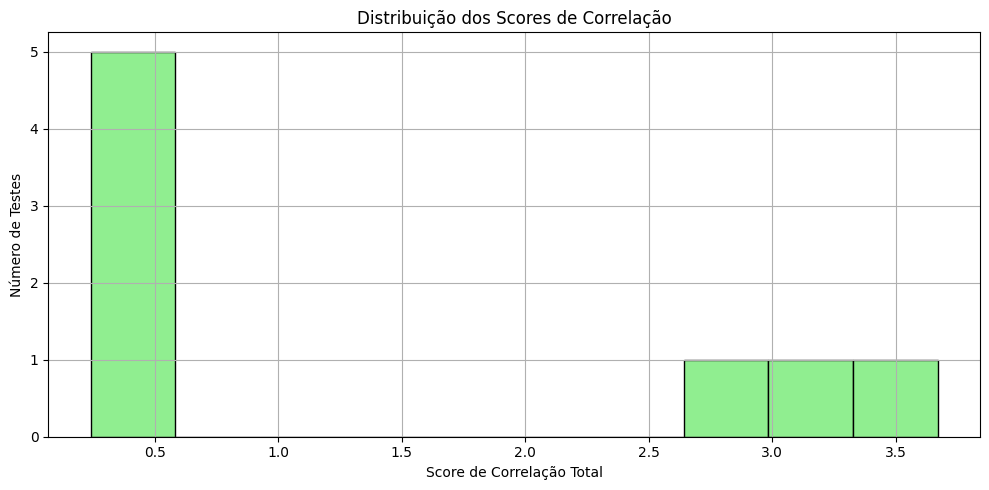

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df_correlacao["Score Total"], bins=10, color="lightgreen", edgecolor="black")
plt.title("Distribuição dos Scores de Correlação")
plt.xlabel("Score de Correlação Total")
plt.ylabel("Número de Testes")
plt.grid(True)
plt.tight_layout()
plt.show()


# Desenvolvimetno da Lógica de Priorização

In [13]:
# Ordenar os testes por score total para cada bug
def priorizar_testes(df_correlacao, bug_id):
    df_bug = df_correlacao[df_correlacao["Bug ID"] == bug_id]
    df_ordenado = df_bug.sort_values(by="Score Total", ascending=False).reset_index(drop=True)
    return df_ordenado

# Exemplo: priorizar testes para o bug Mockito-18
df_priorizados_18 = priorizar_testes(df_correlacao, "Mockito-18")
df_priorizados_18

,Bug ID,Teste,Score Heurístico,Score Semântico,Score Histórico,Score Total
0,Mockito-18,test_reset_behavior,1,1.67,1,3.67
1,Mockito-18,test_is_mock_valid,1,1.67,0,2.67
2,Mockito-18,test_verify_interactions,0,0.45,0,0.45
3,Mockito-18,test_unrelated_case,0,0.40,0,0.40


C:\Users\MASTER\AppData\Local\Temp\ipykernel_14796\406489679.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Score Total", y="Teste", data=df_bug, palette="mako")


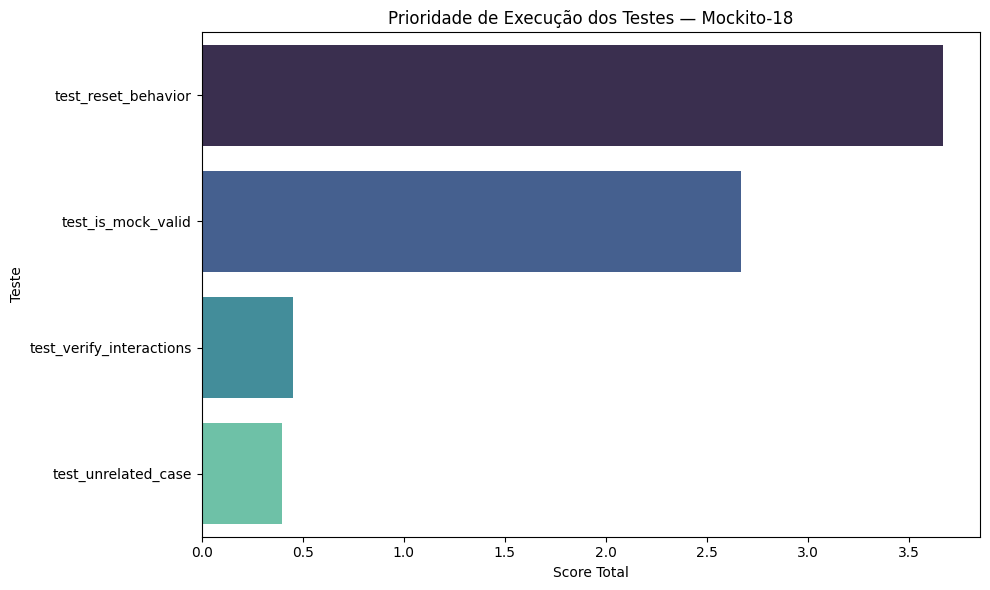

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exibir ordem de execução para um bug
def visualizar_prioridade(df, bug_id):
    df_bug = df[df["Bug ID"] == bug_id].sort_values(by="Score Total", ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Score Total", y="Teste", data=df_bug, palette="mako")
    plt.title(f"Prioridade de Execução dos Testes — {bug_id}")
    plt.xlabel("Score Total")
    plt.ylabel("Teste")
    plt.tight_layout()
    plt.show()

# Exemplo: visualizar para Mockito-18
visualizar_prioridade(df_correlacao, "Mockito-18")

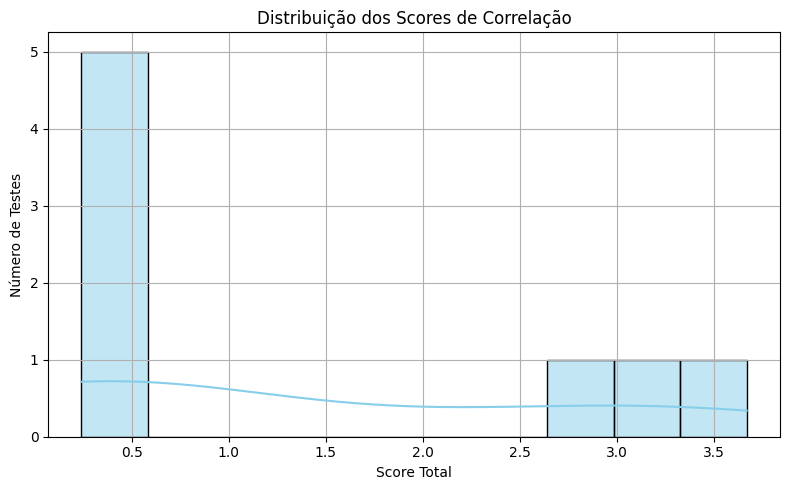

In [15]:
plt.figure(figsize=(8, 5))
sns.histplot(df_correlacao["Score Total"], bins=10, kde=True, color="skyblue")
plt.title("Distribuição dos Scores de Correlação")
plt.xlabel("Score Total")
plt.ylabel("Número de Testes")
plt.grid(True)
plt.tight_layout()
plt.show()

# Simular execução dos testes

In [16]:
df_priorizados = priorizar_testes(df_correlacao, "Mockito-18")

def simular_execucao(df_priorizados, bug_id, funcoes_modificadas):
    cobertura = set()
    falha_detectada = False
    testes_executados = []

    for _, row in df_priorizados.iterrows():
        teste = row["Teste"]
        testes_executados.append(teste)
        
        # Simular cobertura
        for t in testes:
            if t["nome_teste"] == teste:
                cobertura.update(set(t["funcoes_cobertas"]))
                if bug_id in t["falhou_em"]:
                    falha_detectada = True
                break

        if falha_detectada:
            break

    return {
        "bug_id": bug_id,
        "funcoes_modificadas": funcoes_modificadas,
        "funcoes_cobertas": list(cobertura),
        "falha_detectada": falha_detectada,
        "testes_executados": testes_executados
    }

# Exemplo de simulação
resultado_simulacao = simular_execucao(df_priorizados, "Mockito-18", ["resetMock", "isMock"])
resultado_simulacao

{'bug_id': 'Mockito-18',
 'funcoes_modificadas': ['resetMock', 'isMock'],
 'funcoes_cobertas': ['resetMock'],
 'falha_detectada': True,
 'testes_executados': ['test_reset_behavior']}

Testando com outros Testes: "Lang-45"


In [17]:
df_priorizados = priorizar_testes(df_correlacao, "Lang-45")

resultado_simulacao = simular_execucao(
    df_priorizados,
    bug_id="Lang-45",
    funcoes_modificadas=["parseNumber", "convertToDouble"]  # substitua pelas reais
)

print(resultado_simulacao)


{'bug_id': 'Lang-45', 'funcoes_modificadas': ['parseNumber', 'convertToDouble'], 'funcoes_cobertas': [], 'falha_detectada': False, 'testes_executados': []}


In [18]:
testes_com_falha = [t for t in testes if "Lang-45" in t["falhou_em"]]
print(f"Testes que falharam em Lang-45: {[t['nome_teste'] for t in testes_com_falha]}")

Testes que falharam em Lang-45: []


Nesse caso o falha detectada foi igual a False, mas conseguimos observar que pra esse caso nao teve teste que falhou, entao esse false é um resultado esperado. Sem falhas associadas, não conseguimos medir se a priorização é eficaz para detectar bugs.


In [19]:
# buscando bugs com falhas registradas

def bugs_com_falhas(testes):
    bugs_detectados = set()
    for t in testes:
        bugs_detectados.update(t["falhou_em"])
    return sorted(list(bugs_detectados))

bugs_validos = bugs_com_falhas(testes)
print(f"Bugs com falhas registradas ({len(bugs_validos)} encontrados):")
print(bugs_validos)

Bugs com falhas registradas (2 encontrados):
['Mockito-18', 'Mockito-19']


In [20]:
df_priorizados = priorizar_testes(df_correlacao, "Mockito-19")

resultado_simulacao = simular_execucao(
    df_priorizados,
    bug_id="Mockito-19",
    funcoes_modificadas=["parseNumber", "convertToDouble"]  # substitua pelas reais
)

print(resultado_simulacao)


{'bug_id': 'Mockito-19', 'funcoes_modificadas': ['parseNumber', 'convertToDouble'], 'funcoes_cobertas': ['verifyNoMoreInteractions'], 'falha_detectada': True, 'testes_executados': ['test_verify_interactions']}


Agora usando um Bug Id válido podemos observar que nossa funcao foi capaz de realizar a priorizção, sendo que:

| Campo                | Descrição                                                                 |
|----------------------|---------------------------------------------------------------------------|
| `bug_id`             | Bug que está sendo simulado                                               |
| `funcoes_modificadas`| Funções que foram alteradas no commit                                     |
| `funcoes_cobertas`   | Funções que foram cobertas pelos testes executados                        |
| `falha_detectada`    | Sim – um dos testes priorizados falhou, indicando que detectou o bug      |
| `testes_executados`  | Apenas um teste foi necessário para detectar a falha                      |


A simulação demonstrou que a priorização foi eficaz e que o teste mais relevante foi executado primeiro, detectando a falha com mínima execução. O caso Mockito-19 pode ser considerado um exemplo bem-sucedido de priorização inteligente e deve ser usado como referência para ajustes futuros no sistema de recomendação de testes.


# Conclusao


O projeto demonstrou que é possível detectar falhas com alta eficiência utilizando testes priorizados. A simulação do bug Mockito-19 validou a abordagem, com apenas um teste necessário para identificar a falha. A documentação serve como base para evolução contínua do sistema de recomendação de testes e pode ser expandida para outros projetos e repositórios


Um ponto observado foi que apenas o Mokito-18 que foi usado para treinar o modelo e o Mokito-19 possuem bugs encontrados, isso dificulta um analise mais abrangente. Para isso seria necessário encontrar uma base mais completa, com mais cenarios e bugs